In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr, f_oneway
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
# Visualization settings
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'

Load data

In [2]:
data = pd.read_csv('weather_prediction_dataset.csv')

df = pd.DataFrame(data)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df.set_index('DATE', inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2000-01-01 to 2010-01-01
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MONTH                      3654 non-null   int64  
 1   HEATHROW_cloud_cover       3654 non-null   int64  
 2   HEATHROW_humidity          3654 non-null   float64
 3   HEATHROW_pressure          3654 non-null   float64
 4   HEATHROW_global_radiation  3654 non-null   float64
 5   HEATHROW_precipitation     3654 non-null   float64
 6   HEATHROW_sunshine          3654 non-null   float64
 7   HEATHROW_temp_mean         3654 non-null   float64
 8   HEATHROW_temp_min          3654 non-null   float64
 9   HEATHROW_temp_max          3654 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 314.0 KB


,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max
DATE,,,,,,,,,,
2000-01-01,1,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8
2000-01-02,1,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5
2000-01-03,1,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5
2000-01-04,1,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0
2000-01-05,1,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8


# Seasonality (Distribution)

## Distribution by season

In [3]:
def get_season(date):
    year = date.year
    seasons = {
        'spring': pd.date_range(start=str(year)+'-03-21', end=str(year)+'-06-20'),
        'summer': pd.date_range(start=str(year)+'-06-21', end=str(year)+'-09-22'),
        'autumn': pd.date_range(start=str(year)+'-09-23', end=str(year)+'-12-20')
    }
    
    for season, season_range in seasons.items():
        if date in season_range:
            return season
    return 'winter'

# Add season column
df['SEASON'] = df.index.map(get_season)

# Group by season and calculate means
seasonal_means = df.groupby('SEASON').mean().reindex(['spring', 'summer', 'autumn', 'winter'])

seasonal_means.head()

,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max
SEASON,,,,,,,,,,
spring,4.652174,5.120652,0.709696,1.014858,1.829196,0.151935,5.851413,12.804457,8.419891,17.244891
summer,7.691489,5.038298,0.703745,1.015519,1.851011,0.162755,6.136702,18.126596,13.585745,22.637553
autumn,10.696629,5.303371,0.821876,1.014168,0.542112,0.228202,2.958315,9.929326,6.703258,13.080562
winter,3.094027,5.638274,0.802135,1.016199,0.518186,0.172080,2.671792,6.131416,3.052212,9.239934


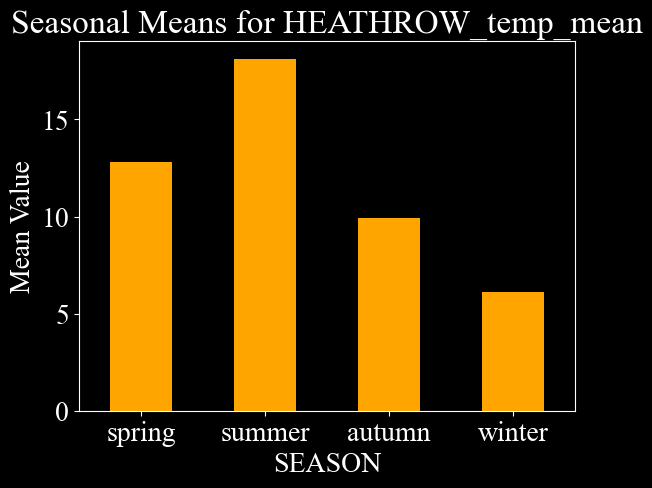

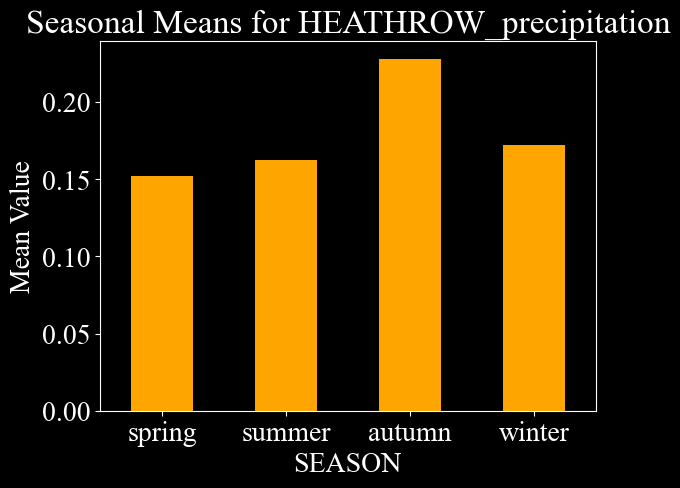

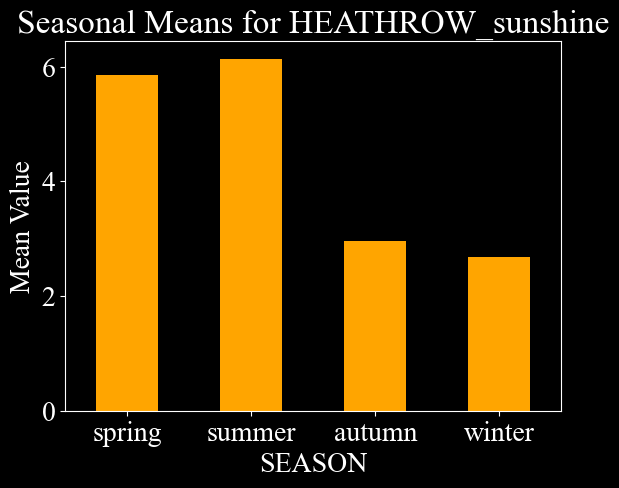

In [4]:
def plot_seasonal_means(df, columns, ylabel):
    for column in columns:
        df[column].plot(kind='bar', color='orange')
        plt.title(f'Seasonal Means for {column}')
        plt.ylabel(ylabel)
        plt.xticks(rotation=0)
        plt.show()

        
plot_seasonal_means(seasonal_means, ['HEATHROW_temp_mean', 'HEATHROW_precipitation', 'HEATHROW_sunshine'], 'Mean Value')

## Temp distribution by month

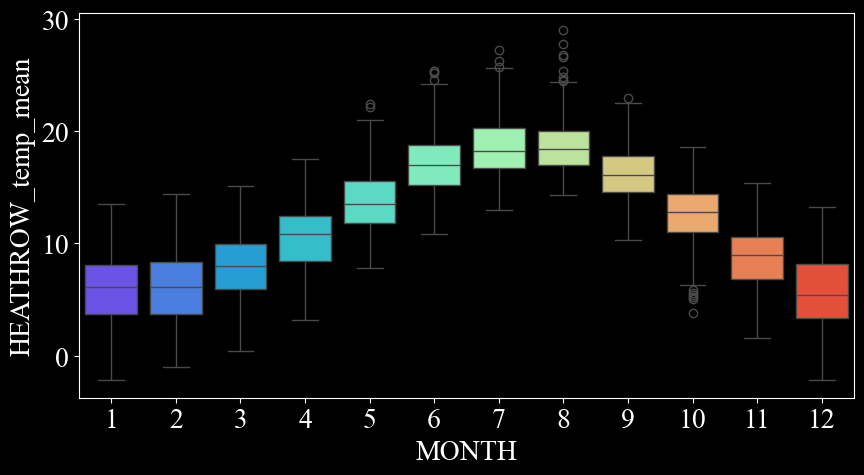

In [5]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='MONTH', y='HEATHROW_temp_mean', palette='rainbow')

plt.show()

# Correlations

### Hypothesis 1: There is a significant correlation between temp and sunshine

    Null Hypothesis (H0): There is no correlation.
    Alternative Hypothesis (H1): There is a significant correlation.

In [6]:
# Pearson corr with temp_mean
corr_coef, p_value = pearsonr(df['HEATHROW_temp_mean'], df['HEATHROW_sunshine'])

alpha = 0.05
print(f'Correlation coefficient: {corr_coef}')
print(f'p-value: {p_value}')
if p_value <= alpha:
    print('Reject H0: There is a significant correlation between temperature and sunshine')
else:
    print('Fail to reject H0: There is no significant correlation between temperature and sunshine')

Correlation coefficient: 0.3772154123731647
p-value: 6.632694639376721e-124
Reject H0: There is a significant correlation between temperature and sunshine


### Hypothesis 2: Mean Temp increasing over the years

    Null Hypothesis (H0): The slope of the regression line is zero (no increase in mean temperature over the years).
    Alternative Hypothesis (H1): The slope of the regression line is greater than zero (mean temperature has increased over the years).

In [7]:
# year average temp
df['YEAR'] = df.index.year
year_avg_temp = df.groupby('YEAR')['HEATHROW_temp_mean'].mean()

# Linear regression
x = year_avg_temp.index.values
y = year_avg_temp.values

x = sm.add_constant(x.reshape(-1, 1))
model = sm.OLS(y, x).fit() # Ordinary Least Squares

print(model.summary())
if model.pvalues[1] <= alpha:
    print('Reject H0: There is a significant correlation between year and temperature')
else:
    print('Fail to reject H0: There is no significant correlation between year and temperature')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     2.837
Date:                Mon, 11 Dec 2023   Prob (F-statistic):              0.126
Time:                        16:28:25   Log-Likelihood:                -26.016
No. Observations:                  11   AIC:                             56.03
Df Residuals:                       9   BIC:                             56.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        927.8105    544.376      1.704      0.1

### Question 3: Sets of features that best predict Temp

#### Method 1: Correlation table

Index(['HEATHROW_global_radiation', 'HEATHROW_temp_mean', 'HEATHROW_temp_min',
       'HEATHROW_temp_max'],
      dtype='object')


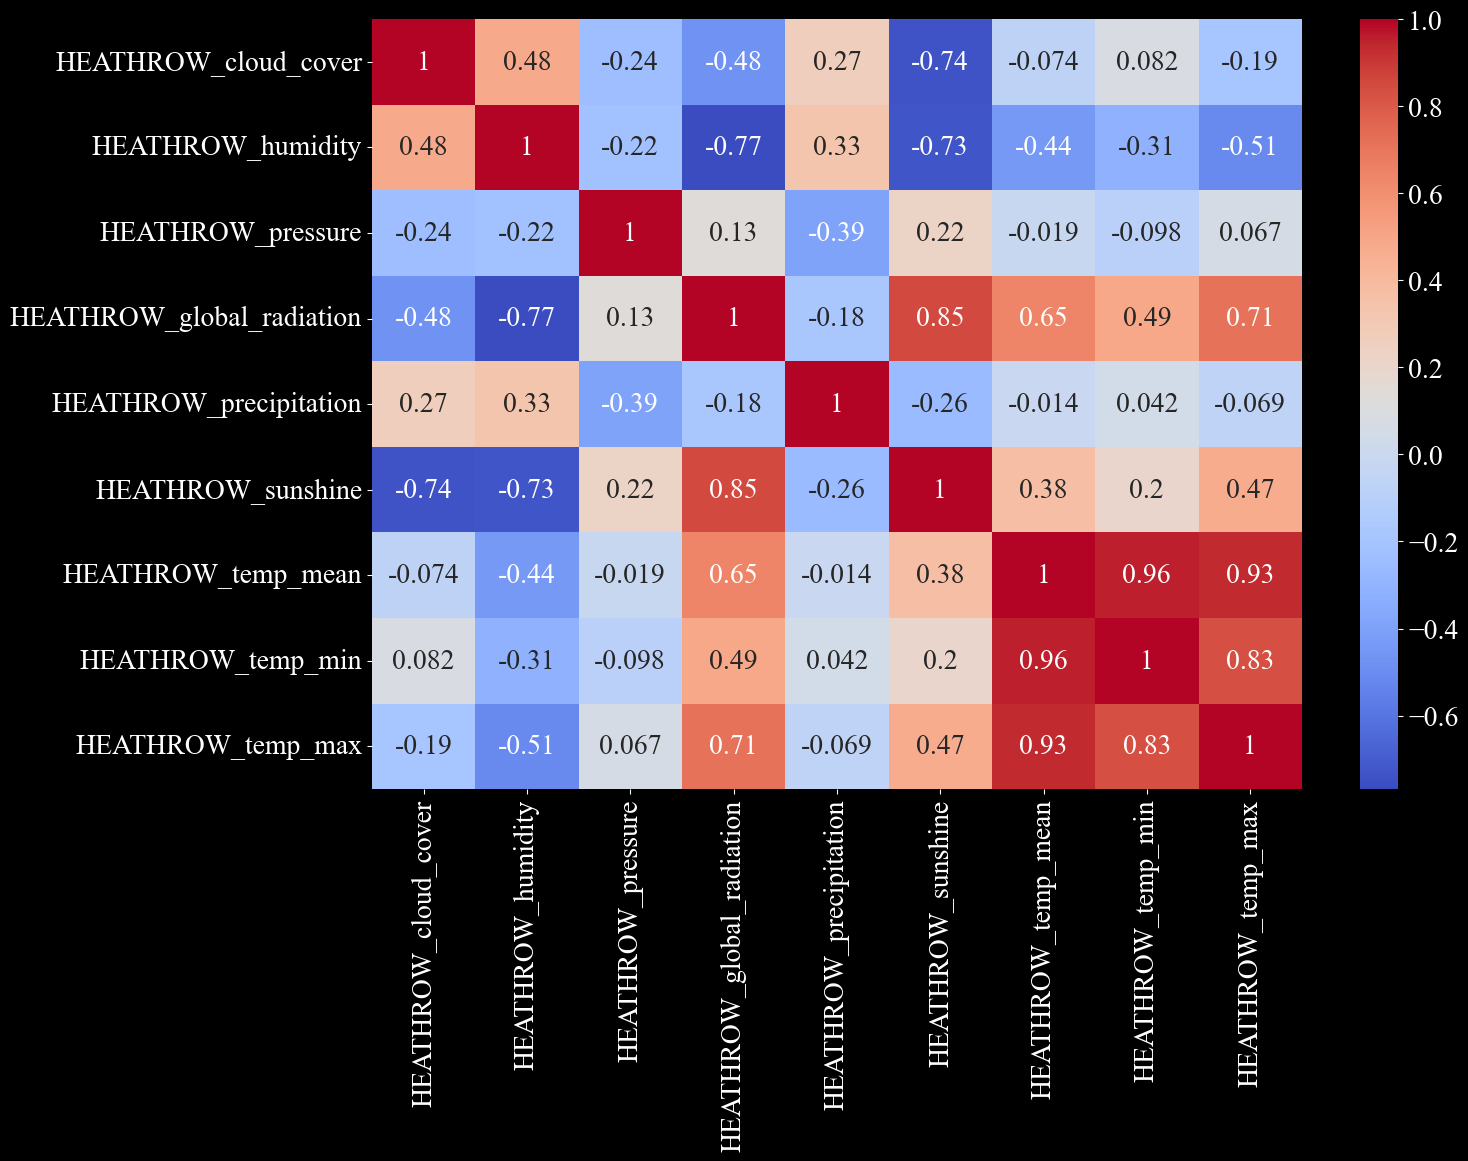

In [8]:
# corr matrix
df_num = df.select_dtypes(include=['float64', 'int64']).drop(['MONTH'], axis=1)
corr = df_num.corr()

top_features = corr.index[abs(corr['HEATHROW_temp_mean']) > 0.5]
print(top_features)

# heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

#### Method 2: ML Feature Importance

In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(df_num.drop(['HEATHROW_temp_mean'], axis=1), df_num['HEATHROW_temp_mean'])

# Feature importance
importance = model.feature_importances_
importance = sorted(zip(df_num.drop(['HEATHROW_temp_mean'], axis=1).columns, importance), key=lambda x: x[1], reverse=True)
print(importance)

[('HEATHROW_temp_min', 0.8729312532858013), ('HEATHROW_temp_max', 0.11175840306064279), ('HEATHROW_global_radiation', 0.004096276792255889), ('HEATHROW_sunshine', 0.0036967246176475726), ('HEATHROW_humidity', 0.0029268697860782063), ('HEATHROW_pressure', 0.0020540626060280747), ('HEATHROW_cloud_cover', 0.0014867102514011027), ('HEATHROW_precipitation', 0.001049699600145006)]


# Predicting Temp using MLP Regressor

In [10]:
data = pd.read_csv('weather_prediction_dataset.csv')
df = pd.DataFrame(data)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

df['DAY'] = df['DATE'].dt.day

df.head()

,DATE,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,DAY
0,2000-01-01,1,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,1
1,2000-01-02,1,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,2
2,2000-01-03,1,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,3
3,2000-01-04,1,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,4
4,2000-01-05,1,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,5


In [11]:
# cyclical 
df['DAY_sin'] = np.sin(df['DAY']*(2.*np.pi/31))
df['DAY_cos'] = np.cos(df['DAY']*(2.*np.pi/31))
df['MONTH_sin'] = np.sin((df['MONTH']-1)*(2.*np.pi/12))
df['MONTH_cos'] = np.cos((df['MONTH']-1)*(2.*np.pi/12))

# drop columns
target = df['HEATHROW_temp_mean']
df = df.drop(['HEATHROW_temp_mean', 'DATE', 'DAY', 'MONTH','HEATHROW_temp_max','HEATHROW_temp_min'], axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=0)

# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

MLPRegressor

In [12]:
# model
model_mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), activation='relu', learning_rate='adaptive',
                     max_iter=1000, random_state=0, alpha=0.01, solver='adam')
model_mlp.fit(X_train, y_train)

# predictions
y_pred_mlp = model_mlp.predict(X_test)

Tinkering around hyperparameters 

In [13]:
# parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 50, 50), (100, 100, 100)],
    'activation': ['tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01],
}

scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': 'r2'
}

# Create the MLPRegressor object
mlp = MLPRegressor(max_iter=1000, random_state=0, learning_rate='adaptive', alpha=0.01, solver='adam')

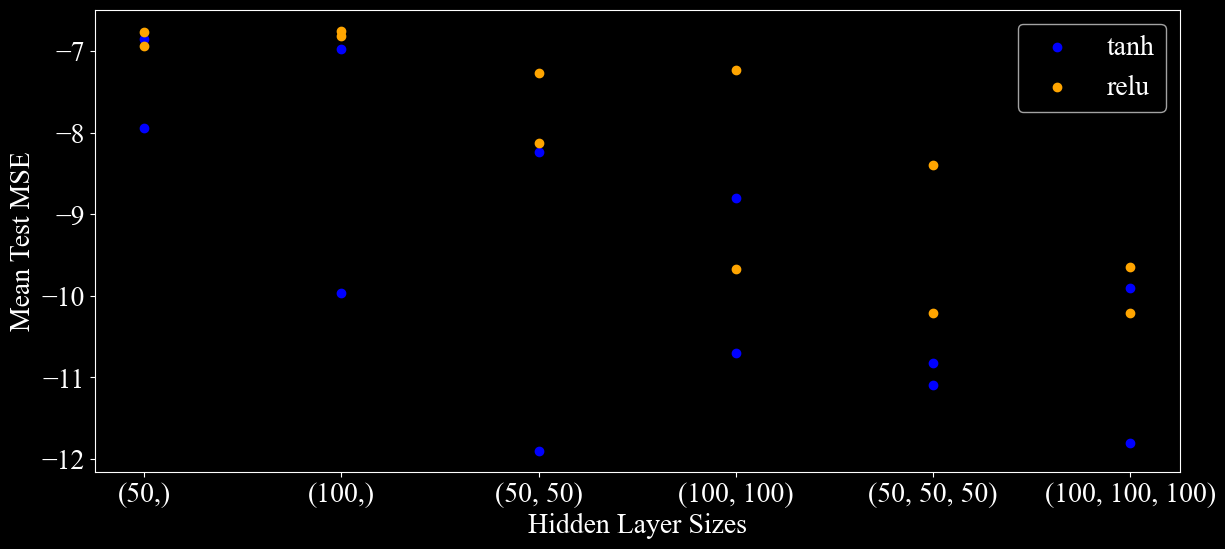

In [14]:
# GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring=scoring, refit='MSE', return_train_score=True, n_jobs=-1)

# fit the model
grid_search.fit(X_train, y_train)

# get the results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# convert tuples to strings for plotting purposes
results['hidden_layer_sizes_str'] = results['param_hidden_layer_sizes'].apply(lambda x: str(x))

# plot
fig, ax = plt.subplots(figsize=(14, 6))
colors = {'tanh': 'blue', 'relu': 'orange'}

for activation in results['param_activation'].unique():
    subset = results[results['param_activation'] == activation]
    ax.scatter(subset['hidden_layer_sizes_str'], subset['mean_test_MSE'], color=colors[activation], label=activation)

ax.set_xlabel('Hidden Layer Sizes')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

Some other regressors as baseline

In [15]:
# linear regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# knn regressor
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

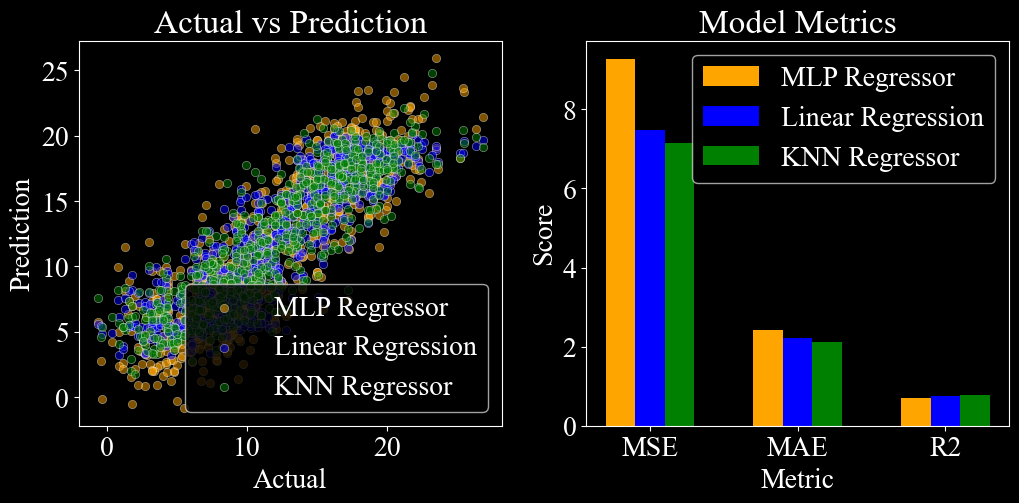

In [21]:
# evaluation
metrics_mlp = [mean_squared_error(y_test, y_pred_mlp), mean_absolute_error(y_test, y_pred_mlp), r2_score(y_test, y_pred_mlp)]
metrics_lr = [mean_squared_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_lr), r2_score(y_test, y_pred_lr)]
metrics_knn = [mean_squared_error(y_test, y_pred_knn), mean_absolute_error(y_test, y_pred_knn), r2_score(y_test, y_pred_knn)]

# plot
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=y_test, y=y_pred_mlp, color='orange', label='MLP Regressor', alpha=0.5, ax=ax1)
sns.scatterplot(x=y_test, y=y_pred_lr, color='blue', label='Linear Regression', alpha=0.5, ax=ax1)
sns.scatterplot(x=y_test, y=y_pred_knn, color='green', label='KNN Regressor', alpha=0.5, ax=ax1)
ax1.set_title('Actual vs Prediction')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Prediction')
# ax1.legend()

metrics_labels = ['MSE', 'MAE', 'R2']
x = np.arange(len(metrics_labels))
width = 0.2
ax2.bar(x-width, metrics_mlp, width, color='orange', label='MLP Regressor')
ax2.bar(x, metrics_lr, width, color='blue', label='Linear Regression')
ax2.bar(x+width, metrics_knn, width, color='green', label='KNN Regressor')
ax2.set_title('Model Metrics')
ax2.set_xlabel('Metric')    
ax2.set_ylabel('Score')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_labels)
# ax2.legend()

plt.legend()
plt.show()